## Bibliotecas

In [29]:
using LinearAlgebra
using Plots
using GaussQuadrature
using SparseArrays
using DataFrames

# Definições iniciais

## Definição das f's das equações e suas soluções analíticas 

In [2]:
function f1(x::Float64, α::Float64, β::Float64)
    return -2*α + β*(x^2-x)
end

function u1(x::Float64)
    return x*(x-1)
end

function f2(x::Float64, α::Float64, β::Float64)
    return (α*π^2 + β)*sin(π*x)
end

function u2(x::Float64)
    return sin(π*x)
end

function f3(x::Float64, α::Float64, β::Float64)
    return 8.0::Float64
end

function u3(x::Float64)
    return -4*x*(x-1)::Float64
end

function f4(x::Float64, α::Float64, β::Float64)
    return x::Float64
end

function u4(x::Float64)
    return x + (exp(-x) - exp(x))/(exp(1) - exp(-1)) ::Float64
end

u4 (generic function with 1 method)

## Base

In [3]:
function ϕ₁(ξ)
    return (1.0 - ξ)/2.0 :: Float64
end

function ϕ₂(ξ)
    return (1.0 + ξ)/2.0 :: Float64
end

function dϕ₁(ξ)
    return -1.0/2.0 :: Float64
end

function dϕ₂(ξ)
    return 1.0/2.0 :: Float64
end

dϕ₂ (generic function with 1 method)

## Funções auxiliares de cálculo

In [4]:
function get_point(index::Int64, m::Int64)
    return convert(Float64, index/(m+1))     
end

function map_ξ_x(ξ, x_i_inf, h)
    return x_i_inf + ((h*(ξ+1))/2.0)
end

function quadratura_F_local(f, ϕ, α, β, e, m)
    pontos, pesos = legendre(5)
    quad = 0
    
    h = 1/(m+1)
    x_i_inf = get_point(e-1, m)
    
    for (ξ, W) in zip(pontos, pesos)
         quad += W*( f(map_ξ_x(ξ, x_i_inf, h), α, β) * ϕ(ξ)) 
    end
    
    return quad
end
    

function quadratura_phis_K(f1, f2)
    pontos, pesos = legendre(5)
    quad = 0
    
    for (ξ, W) in zip(pontos, pesos)
         quad += W*( f1(ξ) * f2(ξ) ) 
    end
    
    return quad
end

quadratura_phis_K (generic function with 1 method)

## Funções auxiliares de visualização

In [5]:
function plot_exact_and_numerical(ne::Int64, f_exact, sol_on_points, isContinous::Bool)
    m = ne-1
    points = get_point.(0:ne, m)
    plot(f_exact, range(0, 1, 100), lw=3, label="Solução Exata")

    if(isContinous)
        display(plot!(points, sol_on_points, lw=3, markershape=:circle, label="Solução Numérica"))
    else 
        display(plot!(points, sol_on_points, lw=3, seriestype=:scatter, label="Solução Numérica"))
    end

end

function plot_exact_and_numerical(ne::Int64, u, t, α, β, sol_on_points, isContinous::Bool)
    m = ne-1
    points = get_point.(0:ne, m)
    
    u_on_points = u.((range(0, 1, 100), t, α, β)...)
    
    plot(range(0, 1, 100), u_on_points, lw=3, label="Solução Exata")

    if(isContinous)    
        display(plot!(points, sol_on_points, lw=3, markershape=:circle, label="Solução Numérica"))
    else     
        display(plot!(points, sol_on_points, lw=3, seriestype=:scatter, label="Solução Numérica"))
    end
end

plot_exact_and_numerical (generic function with 2 methods)

## Funções principais de resolução

In [6]:
function monta_LG(ne)
    return transpose(hcat(1:ne, 2:ne+1))
end

function monta_EQ(ne)
    m = ne-1
    return vcat(m+1, 1:m, m+1)
end

function monta_F_local(f, α, β, m, e)
    h = 1/(m+1)
    
    F_local = zeros(2)
    F_local[1] = h/2 * quadratura_F_local(f, ϕ₁, α, β, e, m)
    F_local[2] = h/2 * quadratura_F_local(f, ϕ₂, α, β, e, m)

    return F_local    
end

function monta_K_local(α, β, m)
    h = 1/(m+1)
    K_local = zeros(2, 2)
    
    K_local[1, 1] = (2*α/h) * quadratura_phis_K(dϕ₁, dϕ₁) + (β*h/2) * quadratura_phis_K(ϕ₁, ϕ₁)
    K_local[1, 2] = K_local[2, 1] = (2*α/h) * quadratura_phis_K(dϕ₁, dϕ₂) + (β*h/2) * quadratura_phis_K(ϕ₁, ϕ₂)
    K_local[2, 2] = (2*α/h) * quadratura_phis_K(dϕ₂, dϕ₂) + (β*h/2) * quadratura_phis_K(ϕ₂, ϕ₂)    
    
    return K_local
end

function monta_F_global(f, α, β, ne, EQoLG)
    m = ne-1
    F_global = zeros(m+1)

    for e in 1:m+1
        F_local = monta_F_local(f, α, β, m, e)
        for i in 1:2
            index = EQoLG[i, e]
            F_global[index] += F_local[i]
        end
    end
    
    return F_global[1:m]
end

function monta_K_global(α, β, ne, EQoLG)
    m = ne-1
    K_global = spzeros(m+1,m+1)
    K_local = monta_K_local(α, β, m)
    
    for e in 1:m+1
        for i in 1:2
            for j in 1:2
                i_global = EQoLG[i, e]
                j_global = EQoLG[j, e]
                
                K_global[i_global, j_global] += K_local[i, j]
            end
        end
    end
    
    
    return K_global[1:m, 1:m]
    
end

function monta_uh(c)    
    return vcat(0, c, 0)
end

monta_uh (generic function with 1 method)

## Cálculo do Erro

In [7]:
function erro_L2(u, c̄, ne)
    m = ne-1
    h = 1/(m+1)
    
    pontos, pesos = legendre(5)
    erro_quadrado = 0

    for e in 1:ne
        x_i_inf = get_point(e-1, m)

        for (ξ, W) in zip(pontos, pesos)
            erro_quadrado += W * (u(map_ξ_x(ξ, x_i_inf, h)) - c̄[e]*ϕ₁(ξ) - c̄[e+1]*ϕ₂(ξ))^2 
        end
    end
    
    return sqrt(erro_quadrado * h/2)    
end

erro_L2 (generic function with 1 method)

In [8]:
function erro_L2_parabolico(u, α, β, c̄, ne)
    m = ne-1
    h = 1/(m+1)
    
    pontos, pesos = legendre(5)
    erro_quadrado = 0

    for e in 1:ne
        x_i_inf = get_point(e-1, m)

        for (ξ, W) in zip(pontos, pesos)
            erro_quadrado += W * (u(map_ξ_x(ξ, x_i_inf, h), α, β) - c̄[e]*ϕ₁(ξ) - c̄[e+1]*ϕ₂(ξ))^2 
        end
    end
    
    return sqrt(erro_quadrado * h/2)    
end

erro_L2_parabolico (generic function with 1 method)

## Estudo de Convergência

In [9]:
function estudo_convergencia(n_testes, f, u, α, β)
    ne_list = 2 .^ (2:n_testes) 
    h_list = []
    erros = []
    
    for ne in ne_list
        m = ne-1
        h = 1/(m+1)
        
        LG = monta_LG(ne)
        EQ = monta_EQ(ne)
        EQoLG = EQ[LG]
        
        K = monta_K_global(α, β, ne, EQoLG)
        F = monta_F_global(f, α, β, ne, EQoLG)

        c = K\F
        uh = monta_uh(c)
        
        erro = erro_L2(u, uh, ne)
        push!(erros, erro)
        push!(h_list, h)        
    end

    plot(h_list, erros, lw=3, label="Erro", xscale = :log10, yscale = :log10, markershape=:circle)
    display(plot!(h_list, h_list.^2, lw=3, label="h²", xscale = :log10, yscale = :log10, legend=:topleft))
end

estudo_convergencia (generic function with 1 method)

# Exemplos

In [10]:
function solucao_e_teste(α, β, f, u, ne, n_testes)
    LG = monta_LG(ne)
    EQ = monta_EQ(ne)

    EQoLG = EQ[LG]

    K = monta_K_global(α, β, ne, EQoLG)
    F = monta_F_global(f, α, β, ne, EQoLG)

    c = K\F
    uh = monta_uh(c)

    plot_exact_and_numerical(ne, u, uh, true)
    estudo_convergencia(n_testes, f, u, α, β)
    
    return
end

solucao_e_teste (generic function with 1 method)

## Caso 1

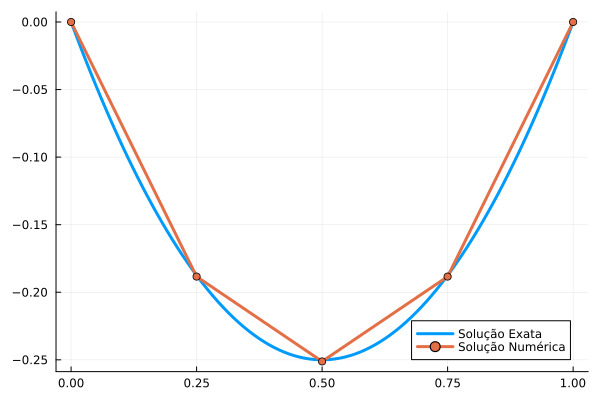

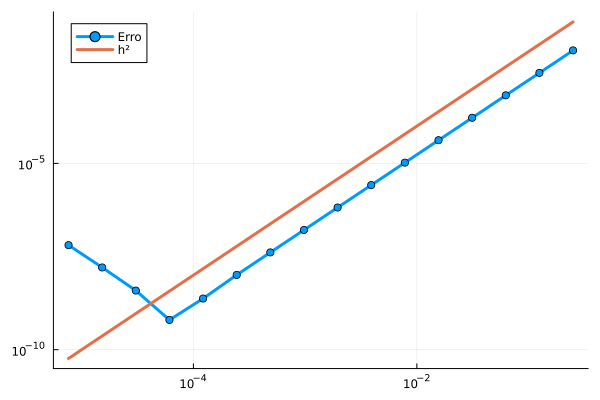

 11.866585 seconds (15.36 M allocations: 1017.270 MiB, 3.65% gc time, 37.19% compilation time: 2% of which was recompilation)


In [11]:
α = 1.0
β = 1.0
f = f1
u = u1
ne = 4
n_testes = 17

@time solucao_e_teste(α, β, f, u, ne, n_testes)

## Caso 2

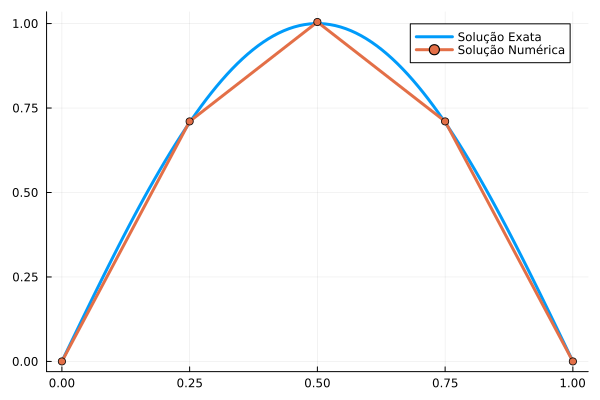

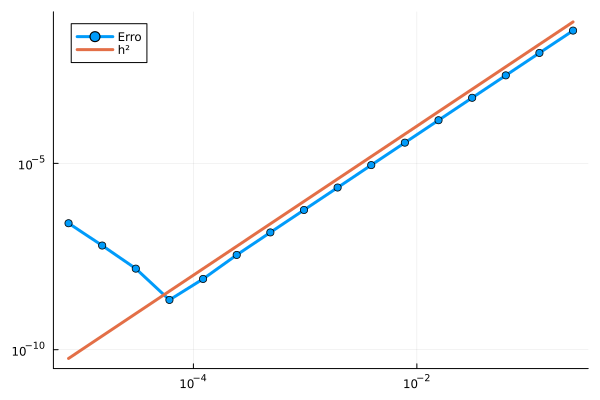

  7.736883 seconds (9.33 M allocations: 582.570 MiB, 3.10% gc time, 3.06% compilation time)


In [12]:
α = 1.0
β = 1.0
f = f2
u = u2
ne = 4
n_testes = 17

@time solucao_e_teste(α, β, f, u, ne, n_testes)

## Caso 3

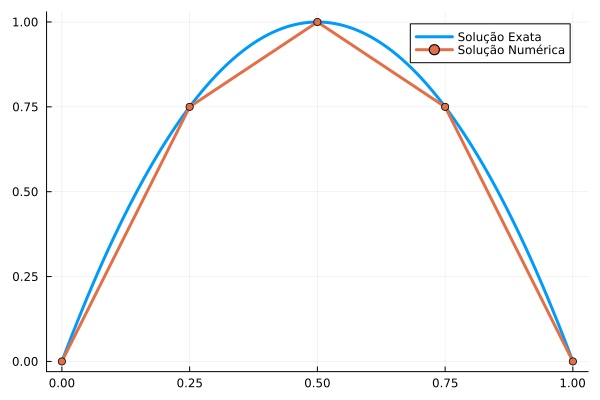

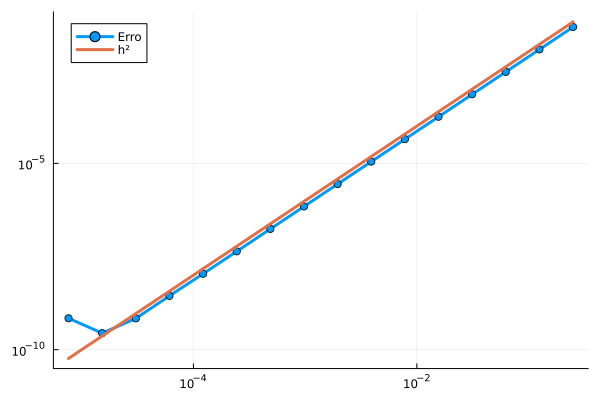

  7.365493 seconds (9.32 M allocations: 582.099 MiB, 0.31% gc time, 1.30% compilation time)


In [13]:
α = 1.0
β = 0.0
f = f3
u = u3
ne = 4
n_testes = 17

@time solucao_e_teste(α, β, f, u, ne, n_testes)

## Caso 4

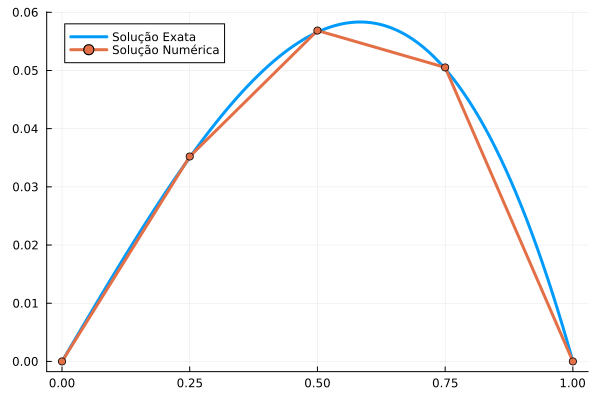

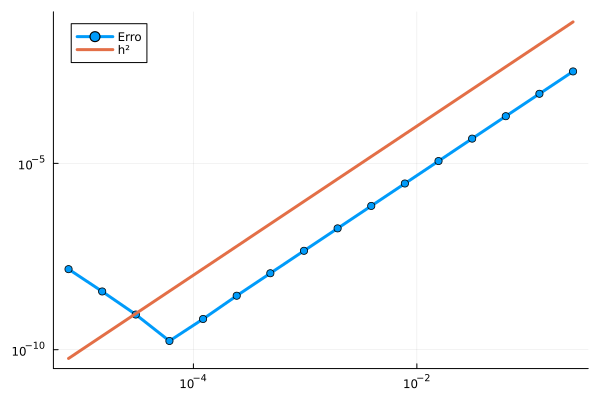

  7.677935 seconds (9.32 M allocations: 581.954 MiB, 3.72% gc time, 1.31% compilation time)


In [14]:
α = 1.0
β = 1.0
f = f4
u = u4
ne = 4
n_testes = 17

@time solucao_e_teste(α, β, f, u, ne, n_testes)

# Nova equação

## Formulação forte

$-α u''(x) + β u(x) + γ u'(x) = f(x); x ∈ ]0, 1[$

$u(0) = u(1) = 0$

### Desenvolvimento: Formulação fraca

$-α u''(x) v(x) + β u(x) v(x) + γ u'(x) v(x) = f(x) v(x)$

$-α \int_{0}^{1} u'' v dx + β \int_{0}^{1} u v dx + γ \int_{0}^{1} u' v dx = \int_{0}^{1} f v dx$

$α \int_{0}^{1} u' v' dx + β \int_{0}^{1} u v dx + γ \int_{0}^{1} u' v dx = \int_{0}^{1} f v dx$

## Formulação fraca

$α \int_{0}^{1} u' v' dx + β \int_{0}^{1} u v dx + γ \int_{0}^{1} u' v dx = \int_{0}^{1} f v dx$

$u, v \in V$

## Problema aproximado: Galerkin

$α \int_{0}^{1} u'^{h} v'^{h} dx + β \int_{0}^{1} u^{h} v^{h} dx + γ \int_{0}^{1} u'^{h} v^{h} dx = \int_{0}^{1} f v^{h} dx$

$u^{h}, v^{h} \in V^{h}$

### Desenvolvimento: Forma matriz-vetor

$α \int_{0}^{1} (\sum_{j=1}^{m} c_j \varphi'_j) v'^{h} dx + β \int_{0}^{1} (\sum_{j=1}^{m} c_j \varphi_j) v^{h} dx + γ \int_{0}^{1} (\sum_{j=1}^{m} c_j \varphi'_j) v^{h} dx = \int_{0}^{1} f v^{h} dx$

$v^h = \varphi_i \forall i \in \{1, 2, ..., m\} $

$α \int_{0}^{1} (\sum_{j=1}^{m} c_j \varphi'_j) \varphi'_i dx + β \int_{0}^{1} (\sum_{j=1}^{m} c_j \varphi_j) \varphi_i dx + γ \int_{0}^{1} (\sum_{j=1}^{m} c_j \varphi'_j) \varphi_i dx = \int_{0}^{1} f \varphi_i dx$

$ \sum_{j=1}^{m} c_j α \int_{0}^{1} \varphi'_j \varphi'_i dx + \sum_{j=1}^{m} c_j β \int_{0}^{1} \varphi_j \varphi_i dx + \sum_{j=1}^{m} c_j γ \int_{0}^{1} \varphi'_j \varphi_i dx = \int_{0}^{1} f \varphi_i dx$

$ \sum_{j=1}^{m} c_j (α \int_{0}^{1} \varphi'_j \varphi'_i dx + β \int_{0}^{1} \varphi_j \varphi_i dx + γ \int_{0}^{1} \varphi'_j \varphi_i dx)  = \int_{0}^{1} f \varphi_i dx$

$K_{i, j} = α \int_{0}^{1} \varphi'_j \varphi'_i dx + β \int_{0}^{1} \varphi_j \varphi_i dx + γ \int_{0}^{1} \varphi'_j \varphi_i dx$

$c = [c_1, c_2, ...,  c_m]^T$

$F_{i} = \int_{0}^{1} f \varphi_i dx$

## Forma matriz-vetor

$K_{m \times m} c_{m \times 1} = F_{m \times 1}$

$K_{i, j} = α \int_{0}^{1} \varphi'_j \varphi'_i dx + β \int_{0}^{1} \varphi_j \varphi_i dx + γ \int_{0}^{1} \varphi'_j \varphi_i dx$

$c = [c_1, c_2, ...,  c_m]^T$

$F_{i} = \int_{0}^{1} f \varphi_i dx$

### Desenvolvimento: Montagem das estruturas locais

## Estruturas Locais

## Funções Auxiliares

In [15]:
function quadratura_F_local_2(f, ϕ, α, β, γ, e, m)
    pontos, pesos = legendre(5)
    quad = 0
    
    h = 1/(m+1)
    x_i_inf = get_point(e-1, m)
    
    for (ξ, W) in zip(pontos, pesos)
         quad += W*( f(map_ξ_x(ξ, x_i_inf, h), α, β, γ) * ϕ(ξ)) 
    end
    
    return quad
end

quadratura_F_local_2 (generic function with 1 method)

## Funções Principais

In [16]:
function monta_F_local_2(f, α, β, γ, m, e)
    h = 1/(m+1)
    
    F_local = zeros(2)
    F_local[1] = h/2 * quadratura_F_local_2(f, ϕ₁, α, β, γ, e, m)
    F_local[2] = h/2 * quadratura_F_local_2(f, ϕ₂, α, β, γ, e, m)

    return F_local    
end

function monta_K_local_2(α, β, γ, m)
    h = 1/(m+1)
    K_local = zeros(2, 2)
    
    K_local[1, 1] = (2*α/h) * quadratura_phis_K(dϕ₁, dϕ₁) + (β*h/2) * quadratura_phis_K(ϕ₁, ϕ₁) + γ * quadratura_phis_K(ϕ₁, dϕ₁)
    K_local[1, 2] = (2*α/h) * quadratura_phis_K(dϕ₁, dϕ₂) + (β*h/2) * quadratura_phis_K(ϕ₁, ϕ₂) + γ * quadratura_phis_K(ϕ₁, dϕ₂)
    K_local[2, 1] = (2*α/h) * quadratura_phis_K(dϕ₂, dϕ₁) + (β*h/2) * quadratura_phis_K(ϕ₂, ϕ₁) + γ * quadratura_phis_K(ϕ₂, dϕ₁)
    K_local[2, 2] = (2*α/h) * quadratura_phis_K(dϕ₂, dϕ₂) + (β*h/2) * quadratura_phis_K(ϕ₂, ϕ₂) + γ * quadratura_phis_K(ϕ₂, dϕ₂)   
    
    return K_local
end

function monta_F_global_2(f, α, β, γ, ne, EQoLG)
    m = ne-1
    F_global = zeros(m+1)

    for e in 1:m+1
        F_local = monta_F_local_2(f, α, β, γ, m, e)
        for i in 1:2
            index = EQoLG[i, e]
            F_global[index] += F_local[i]
        end
    end
    
    return F_global[1:m]
end

function monta_K_global_2(α, β, γ, ne, EQoLG)
    m = ne-1
    K_global = spzeros(m+1,m+1)
    K_local = monta_K_local_2(α, β, γ, m)
    
    for e in 1:m+1
        for i in 1:2
            for j in 1:2
                i_global = EQoLG[i, e]
                j_global = EQoLG[j, e]
                
                K_global[i_global, j_global] += K_local[i, j]
            end
        end
    end
    
    
    return K_global[1:m, 1:m]
    
end

monta_K_global_2 (generic function with 1 method)

## Funções pra checagem de compatibilidade/corretude

In [17]:
function f3_γ(x::Float64, α::Float64, β::Float64, γ::Float64)
    return 8.0::Float64
end

function f4_γ(x::Float64, α::Float64, β::Float64, γ::Float64)
    return x::Float64
end

function estudo_convergencia_2(n_testes, f, u, α, β, γ)
    ne_list = 2 .^ (2:n_testes) 
    h_list = []
    erros = []
    
    for ne in ne_list
        m = ne-1
        h = 1/(m+1)
        
        LG = monta_LG(ne)
        EQ = monta_EQ(ne)
        EQoLG = EQ[LG]
        
        K = monta_K_global_2(α, β, γ, ne, EQoLG)
        F = monta_F_global_2(f, α, β, γ, ne, EQoLG)

        c = K\F
        uh = monta_uh(c)
        
        erro = erro_L2(u, uh, ne)
        push!(erros, erro)
        push!(h_list, h)        
    end

    plot(h_list, erros, lw=3, label="Erro", xscale = :log10, yscale = :log10, markershape=:circle)
    display(plot!(h_list, h_list.^2, lw=3, label="h²", xscale = :log10, yscale = :log10, legend=:topleft))
end

function solucao_e_teste_2(α, β, γ, f, u, ne, n_testes)
    LG = monta_LG(ne)
    EQ = monta_EQ(ne)

    EQoLG = EQ[LG]

    K = monta_K_global_2(α, β, γ, ne, EQoLG)
    F = monta_F_global_2(f, α, β, γ, ne, EQoLG)

    c = K\F
    uh = monta_uh(c)

    plot_exact_and_numerical(ne, u, uh, true)
    estudo_convergencia_2(n_testes, f, u, α, β, γ)
    
    return
end

solucao_e_teste_2 (generic function with 1 method)

## Checagem

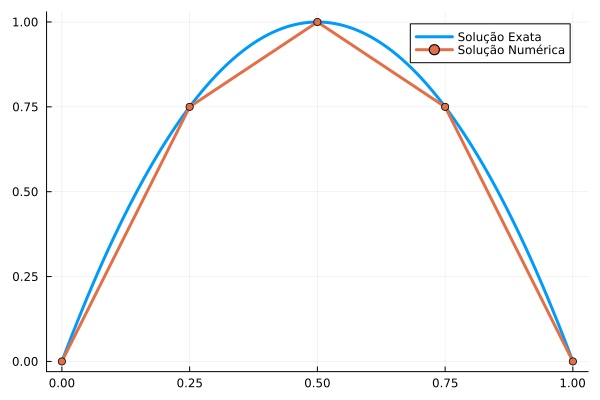

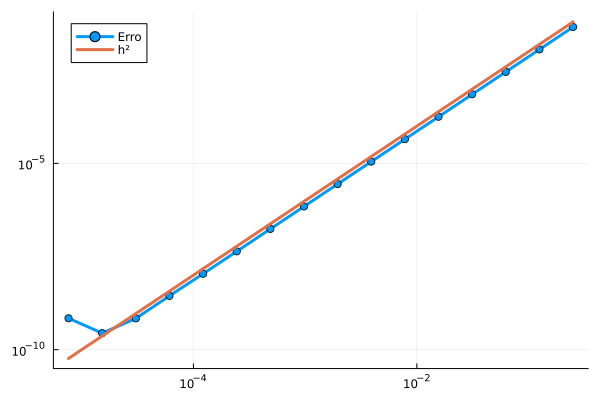

  7.593930 seconds (9.97 M allocations: 598.706 MiB, 0.30% gc time, 3.04% compilation time)


In [18]:
α = 1.0
β = 0.0
γ = 0.0
f = f3_γ
u = u3
ne = 4
n_testes = 17

@time solucao_e_teste_2(α, β, γ, f, u, ne, n_testes)

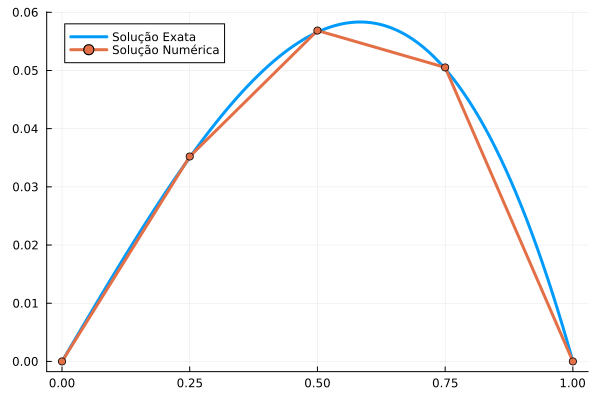

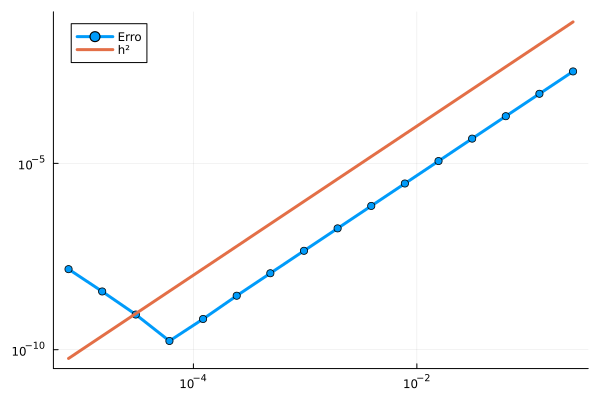

  7.659330 seconds (9.77 M allocations: 585.593 MiB, 3.47% gc time, 0.37% compilation time)


In [19]:
α = 1.0
β = 1.0
γ = 0.0
f = f4_γ
u = u4
ne = 4
n_testes = 17

@time solucao_e_teste_2(α, β, γ, f, u, ne, n_testes)

# Versão com o tempo

## Funções

In [20]:
function f1_parabolica(x, t, α, β)
    return 0
end

function u1_parabolica(x, t, α, β)
    λ = α*π^2 + β
    return (1/(π^2)) * sin(π*x) * ℯ^(-λ*t)
end

function f2_parabolica(x, t, α, β)
    λ = 1
    return ((-λ + α*π^2 + β)/(π^2))*sin(π*x)*ℯ^(-λ*t)
end

function u2_parabolica(x, t, α, β)
    λ = 1
    return (1/(π^2)) * sin(π*x) * ℯ^(-λ*t)
end

u2_parabolica (generic function with 1 method)

In [33]:
function solucao_e_teste_parabolico(α, β, T, N, f, u, u_0, ne)
    m = ne-1
    
    LG = monta_LG(ne)
    EQ = monta_EQ(ne)

    EQoLG = EQ[LG]

    M = monta_K_global(0, 1, ne, EQoLG)
    K = monta_K_global(α, β, ne, EQoLG)
    
    τ = T/N
    t = 0:τ:T
    
    #caso inicial
    Cⁿ = zeros(m, 1)
    Cⁿ_1 = u_0.(get_point.(1:m, m))
    
    A = M + (τ/2)*K
    B = M - (τ/2)*K
    
    display(ne)
    display(EQoLG)
    display(M)
    display(K)
    display(A)
    display(B)    
   
    erros_iteracoes = []
    display(plot_exact_and_numerical(ne, u, t[1], α, β, monta_uh(Cⁿ_1), true))
    push!(erros_iteracoes, erro_L2_parabolico((x, α, β) -> u(x, t[1], α, β), α, β, monta_uh(Cⁿ_1), ne))
    for n in 1:N
        
        display("Cn-1")
        display(Cⁿ_1)
        display("t_medio")
        display((t[n]+t[n+1])/2)
        Fⁿ_meio = monta_F_global((x, α, β) -> f(x, (t[n]+t[n+1])/2, α, β), α, β, ne, EQoLG)
        display("Fn_meio")
        display(Fⁿ_meio)
        
        Cⁿ = A \ ( B * Cⁿ_1 + τ * Fⁿ_meio)
        display("Cn")
        display(Cⁿ)        
        uh = monta_uh(Cⁿ)        
        
        display("uh:")
        display(uh)
        display(plot_exact_and_numerical(ne, u, t[n+1], α, β, uh, true))
        
        Cⁿ_1 = Cⁿ
        erro = erro_L2_parabolico((x, α, β) -> u(x, t[n+1], α, β), α, β, uh, ne)
        push!(erros_iteracoes, erro)
    end
    
    display("Erros L2")
    display(erros_iteracoes)
    display("Máximo erro L2")
    display(maximum(erros_iteracoes))
    #estudo_convergencia(n_testes, f, u, α, β)    
    return
end

solucao_e_teste_parabolico (generic function with 2 methods)

8

2×8 Matrix{Int64}:
 8  1  2  3  4  5  6  7
 1  2  3  4  5  6  7  8

7×7 SparseMatrixCSC{Float64, Int64} with 19 stored entries:
 0.0833333  0.0208333   ⋅          ⋅          ⋅          ⋅          ⋅ 
 0.0208333  0.0833333  0.0208333   ⋅          ⋅          ⋅          ⋅ 
  ⋅         0.0208333  0.0833333  0.0208333   ⋅          ⋅          ⋅ 
  ⋅          ⋅         0.0208333  0.0833333  0.0208333   ⋅          ⋅ 
  ⋅          ⋅          ⋅         0.0208333  0.0833333  0.0208333   ⋅ 
  ⋅          ⋅          ⋅          ⋅         0.0208333  0.0833333  0.0208333
  ⋅          ⋅          ⋅          ⋅          ⋅         0.0208333  0.0833333

7×7 SparseMatrixCSC{Float64, Int64} with 19 stored entries:
 16.0833   -7.97917    ⋅         ⋅         ⋅         ⋅         ⋅ 
 -7.97917  16.0833   -7.97917    ⋅         ⋅         ⋅         ⋅ 
   ⋅       -7.97917  16.0833   -7.97917    ⋅         ⋅         ⋅ 
   ⋅         ⋅       -7.97917  16.0833   -7.97917    ⋅         ⋅ 
   ⋅         ⋅         ⋅       -7.97917  16.0833   -7.97917    ⋅ 
   ⋅         ⋅         ⋅         ⋅       -7.97917  16.0833   -7.97917
   ⋅         ⋅         ⋅         ⋅         ⋅       -7.97917  16.0833

7×7 SparseMatrixCSC{Float64, Int64} with 19 stored entries:
  1.08854   -0.477865    ⋅          ⋅          ⋅          ⋅          ⋅ 
 -0.477865   1.08854   -0.477865    ⋅          ⋅          ⋅          ⋅ 
   ⋅        -0.477865   1.08854   -0.477865    ⋅          ⋅          ⋅ 
   ⋅          ⋅        -0.477865   1.08854   -0.477865    ⋅          ⋅ 
   ⋅          ⋅          ⋅        -0.477865   1.08854   -0.477865    ⋅ 
   ⋅          ⋅          ⋅          ⋅        -0.477865   1.08854   -0.477865
   ⋅          ⋅          ⋅          ⋅          ⋅        -0.477865   1.08854

7×7 SparseMatrixCSC{Float64, Int64} with 19 stored entries:
 -0.921875   0.519531    ⋅          ⋅          ⋅          ⋅          ⋅ 
  0.519531  -0.921875   0.519531    ⋅          ⋅          ⋅          ⋅ 
   ⋅         0.519531  -0.921875   0.519531    ⋅          ⋅          ⋅ 
   ⋅          ⋅         0.519531  -0.921875   0.519531    ⋅          ⋅ 
   ⋅          ⋅          ⋅         0.519531  -0.921875   0.519531    ⋅ 
   ⋅          ⋅          ⋅          ⋅         0.519531  -0.921875   0.519531
   ⋅          ⋅          ⋅          ⋅          ⋅         0.519531  -0.921875

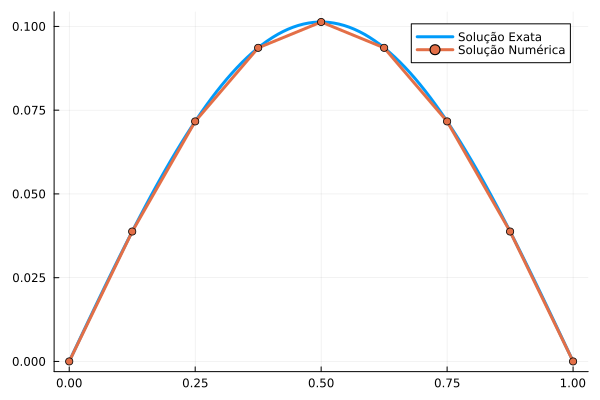

nothing

"Cn-1"

7-element Vector{Float64}:
 0.03877393832754341
 0.07164489603134454
 0.09360856777697325
 0.10132118364233778
 0.09360856777697325
 0.07164489603134454
 0.038773938327543424

"t_medio"

0.0625

"Fn_meio"

7-element Vector{Float64}:
 0.044362696859826675
 0.08197157527159321
 0.10710102442243988
 0.11592531347817413
 0.10710102442243988
 0.08197157527159321
 0.04436269685982669

"Cn"

7-element Vector{Float64}:
 0.0341616602316839
 0.06312251736931507
 0.08247354344451285
 0.08926872015481659
 0.08247354344451285
 0.06312251736931507
 0.03416166023168389

"uh:"

9-element Vector{Float64}:
 0.0
 0.0341616602316839
 0.06312251736931507
 0.08247354344451285
 0.08926872015481659
 0.08247354344451285
 0.06312251736931507
 0.03416166023168389
 0.0

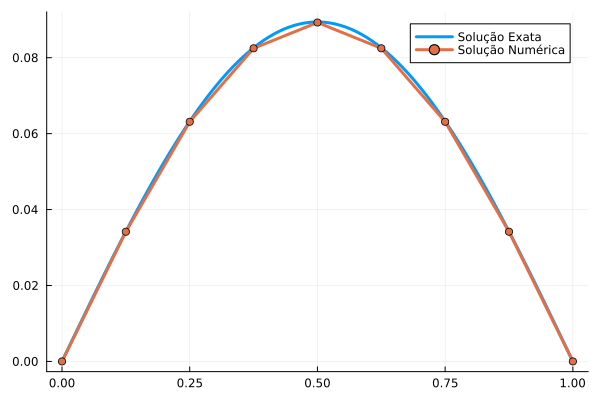

nothing

"Cn-1"

7-element Vector{Float64}:
 0.0341616602316839
 0.06312251736931507
 0.08247354344451285
 0.08926872015481659
 0.08247354344451285
 0.06312251736931507
 0.03416166023168389

"t_medio"

0.1875

"Fn_meio"

7-element Vector{Float64}:
 0.0391499425690964
 0.07233966127716102
 0.0945163223164403
 0.10230373007563691
 0.0945163223164403
 0.07233966127716102
 0.039149942569096416

"Cn"

7-element Vector{Float64}:
 0.030137140980204997
 0.05568617544003707
 0.07275749448556089
 0.07875214454398799
 0.07275749448556089
 0.05568617544003707
 0.030137140980205004

"uh:"

9-element Vector{Float64}:
 0.0
 0.030137140980204997
 0.05568617544003707
 0.07275749448556089
 0.07875214454398799
 0.07275749448556089
 0.05568617544003707
 0.030137140980205004
 0.0

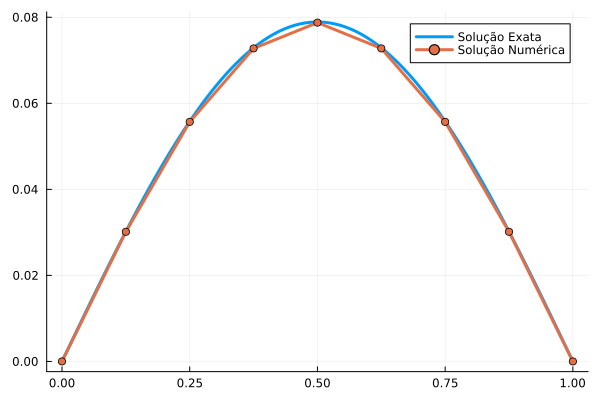

nothing

"Cn-1"

7-element Vector{Float64}:
 0.030137140980204997
 0.05568617544003707
 0.07275749448556089
 0.07875214454398799
 0.07275749448556089
 0.05568617544003707
 0.030137140980205004

"t_medio"

0.3125

"Fn_meio"

7-element Vector{Float64}:
 0.03454970305359237
 0.06383952701111338
 0.08341036168794583
 0.0902827249146001
 0.08341036168794584
 0.0638395270111134
 0.03454970305359238

"Cn"

7-element Vector{Float64}:
 0.026594002906376587
 0.049139309945493995
 0.06420360249436384
 0.06949347857057268
 0.06420360249436385
 0.049139309945493995
 0.02659400290637658

"uh:"

9-element Vector{Float64}:
 0.0
 0.026594002906376587
 0.049139309945493995
 0.06420360249436384
 0.06949347857057268
 0.06420360249436385
 0.049139309945493995
 0.02659400290637658
 0.0

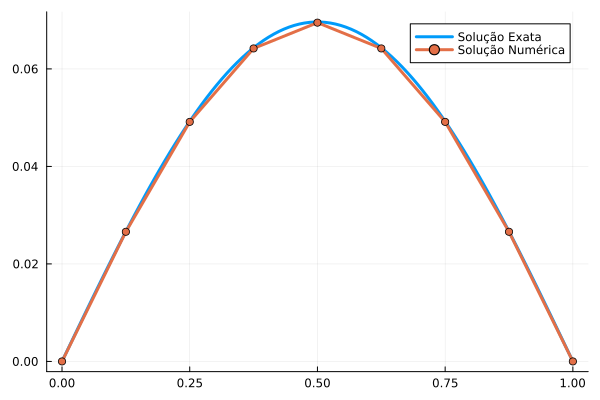

nothing

"Cn-1"

7-element Vector{Float64}:
 0.026594002906376587
 0.049139309945493995
 0.06420360249436384
 0.06949347857057268
 0.06420360249436385
 0.049139309945493995
 0.02659400290637658

"t_medio"

0.4375

"Fn_meio"

7-element Vector{Float64}:
 0.030490005930012803
 0.05633818484977317
 0.073609385833073
 0.07967422509403166
 0.073609385833073
 0.05633818484977319
 0.03049000593001281

"Cn"

7-element Vector{Float64}:
 0.023468767414877596
 0.04336462773574647
 0.05665861658517724
 0.06132684467115314
 0.056658616585177235
 0.043364627735746474
 0.023468767414877606

"uh:"

9-element Vector{Float64}:
 0.0
 0.023468767414877596
 0.04336462773574647
 0.05665861658517724
 0.06132684467115314
 0.056658616585177235
 0.043364627735746474
 0.023468767414877606
 0.0

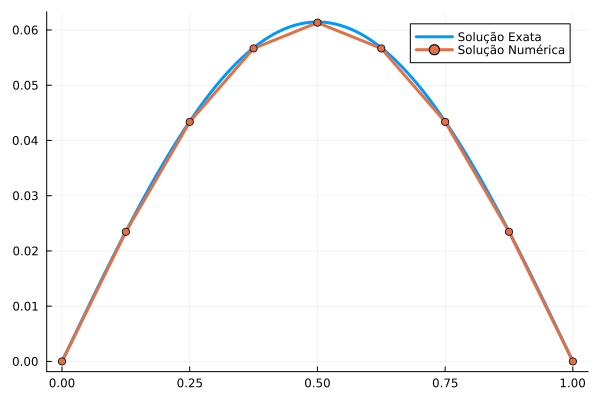

nothing

"Cn-1"

7-element Vector{Float64}:
 0.023468767414877596
 0.04336462773574647
 0.05665861658517724
 0.06132684467115314
 0.056658616585177235
 0.043364627735746474
 0.023468767414877606

"t_medio"

0.5625

"Fn_meio"

7-element Vector{Float64}:
 0.026907335793022243
 0.04971827362716321
 0.06496005499884132
 0.07031225686131079
 0.06496005499884133
 0.04971827362716322
 0.026907335793022256

"Cn"

7-element Vector{Float64}:
 0.020711048250194528
 0.03826902715041684
 0.050000893576583175
 0.05412057721494368
 0.050000893576583195
 0.03826902715041684
 0.020711048250194528

"uh:"

9-element Vector{Float64}:
 0.0
 0.020711048250194528
 0.03826902715041684
 0.050000893576583175
 0.05412057721494368
 0.050000893576583195
 0.03826902715041684
 0.020711048250194528
 0.0

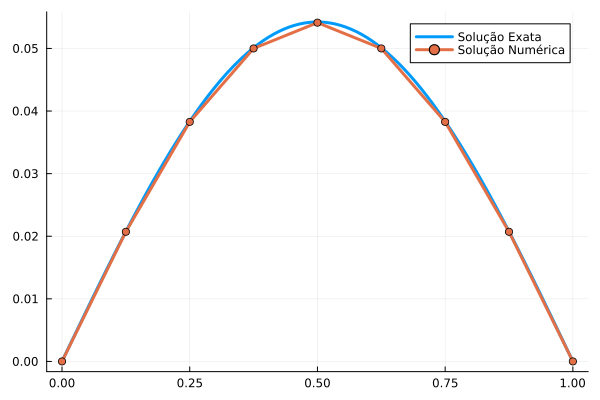

nothing

"Cn-1"

7-element Vector{Float64}:
 0.020711048250194528
 0.03826902715041684
 0.050000893576583175
 0.05412057721494368
 0.050000893576583195
 0.03826902715041684
 0.020711048250194528

"t_medio"

0.6875

"Fn_meio"

7-element Vector{Float64}:
 0.023745640494145747
 0.04387622247782491
 0.05732704732820243
 0.06205034889383923
 0.05732704732820243
 0.04387622247782491
 0.023745640494145757

"Cn"

7-element Vector{Float64}:
 0.01827742364363271
 0.03377227522278025
 0.044125604045696744
 0.04776120965225267
 0.04412560404569673
 0.03377227522278026
 0.018277423643632714

"uh:"

9-element Vector{Float64}:
 0.0
 0.01827742364363271
 0.03377227522278025
 0.044125604045696744
 0.04776120965225267
 0.04412560404569673
 0.03377227522278026
 0.018277423643632714
 0.0

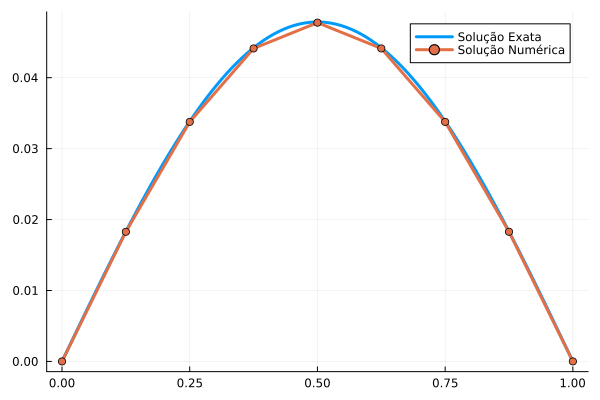

nothing

"Cn-1"

7-element Vector{Float64}:
 0.01827742364363271
 0.03377227522278025
 0.044125604045696744
 0.04776120965225267
 0.04412560404569673
 0.03377227522278026
 0.018277423643632714

"t_medio"

0.8125

"Fn_meio"

7-element Vector{Float64}:
 0.020955454185970966
 0.03872063043379308
 0.05059094170145915
 0.0547592407031066
 0.05059094170145915
 0.03872063043379309
 0.020955454185970973

"Cn"

7-element Vector{Float64}:
 0.016129767475890257
 0.029803924070282494
 0.038940703398218694
 0.04214911363213143
 0.03894070339821872
 0.02980392407028249
 0.016129767475890257

"uh:"

9-element Vector{Float64}:
 0.0
 0.016129767475890257
 0.029803924070282494
 0.038940703398218694
 0.04214911363213143
 0.03894070339821872
 0.02980392407028249
 0.016129767475890257
 0.0

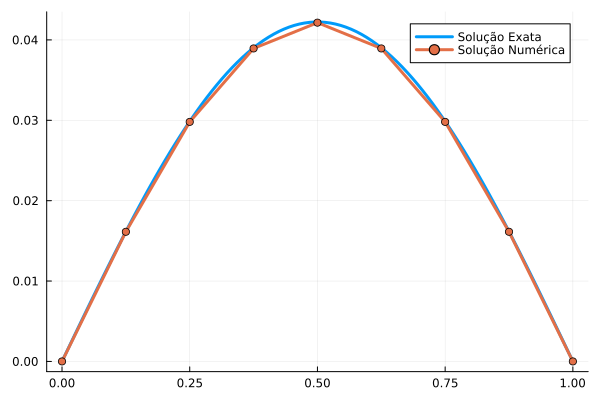

nothing

"Cn-1"

7-element Vector{Float64}:
 0.016129767475890257
 0.029803924070282494
 0.038940703398218694
 0.04214911363213143
 0.03894070339821872
 0.02980392407028249
 0.016129767475890257

"t_medio"

0.9375

"Fn_meio"

7-element Vector{Float64}:
 0.01849312341137277
 0.034170836423945215
 0.044646349350375536
 0.04832486030837588
 0.044646349350375536
 0.03417083642394522
 0.018493123411372776

"Cn"

7-element Vector{Float64}:
 0.014234469414953677
 0.026301869897267228
 0.034365049114766184
 0.037196461124487955
 0.034365049114766164
 0.026301869897267235
 0.01423446941495368

"uh:"

9-element Vector{Float64}:
 0.0
 0.014234469414953677
 0.026301869897267228
 0.034365049114766184
 0.037196461124487955
 0.034365049114766164
 0.026301869897267235
 0.01423446941495368
 0.0

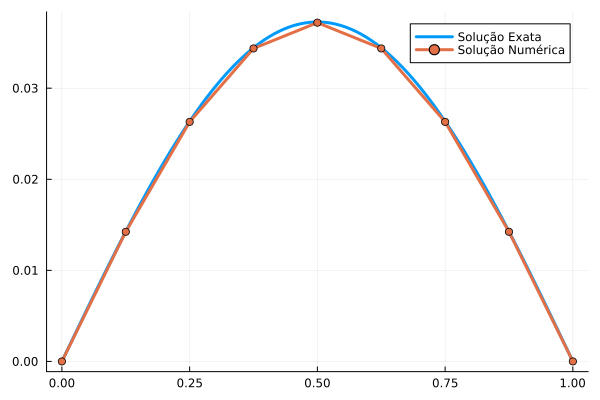

nothing

"Erros L2"

9-element Vector{Any}:
 0.0010051993482519549
 0.0009812233923736492
 0.0008835570551819388
 0.0007830098844920445
 0.0006916106661135774
 0.0006104567407899794
 0.0005387470254921374
 0.00047544644369641097
 0.0004195807296660183

"Máximo erro L2"

0.0010051993482519549

In [34]:
u0(x) = sin(π*x)/π^2
    
solucao_e_teste_parabolico(1, 1, 1, 8, f2_parabolica, u2_parabolica, u0, 8)

In [35]:
function estudo_convergencia_parabolico(α, β, T, f, u, u_0, n_testes)
    ne_list = 2 .^ (2:n_testes) 
    h_list = []
    erros = []
    
    for ne in ne_list
        m = ne-1
        N = ne
        h = 1/ne
        push!(h_list, h)
    
        LG = monta_LG(ne)
        EQ = monta_EQ(ne)

        EQoLG = EQ[LG]

        M = monta_K_global(0, 1, ne, EQoLG)
        K = monta_K_global(α, β, ne, EQoLG)

        τ = T/N
        t = 0:τ:T

        #caso inicial
        Cⁿ = zeros(m, 1)
        Cⁿ_1 = u_0.(get_point.(1:m, m))

        A = M + (τ/2)*K
        B = M - (τ/2)*K  

        erros_iteracoes = []
        push!(erros_iteracoes, erro_L2_parabolico((x, α, β) -> u(x, t[1], α, β), α, β, monta_uh(Cⁿ_1), ne))

        for n in 1:N

            Fⁿ_meio = monta_F_global((x, α, β) -> f(x, (t[n]+t[n+1])/2, α, β), α, β, ne, EQoLG)
            Cⁿ = A \ ( B * Cⁿ_1 + τ * Fⁿ_meio)
            uh = monta_uh(Cⁿ)
            Cⁿ_1 = Cⁿ

            erro = erro_L2_parabolico((x, α, β) -> u(x, t[n+1], α, β), α, β, uh, ne)
            push!(erros_iteracoes, erro)
        end

        push!(erros, maximum(erros_iteracoes))
    end
    
    plot(h_list, erros, lw=3, label="Erro", xscale = :log10, yscale = :log10, markershape=:circle)
    display(plot!(h_list, h_list.^2, lw=3, label="h²", xscale = :log10, yscale = :log10, legend=:topleft))
    display(DataFrame(h=h_list, erro=erros))
end

estudo_convergencia_parabolico (generic function with 2 methods)

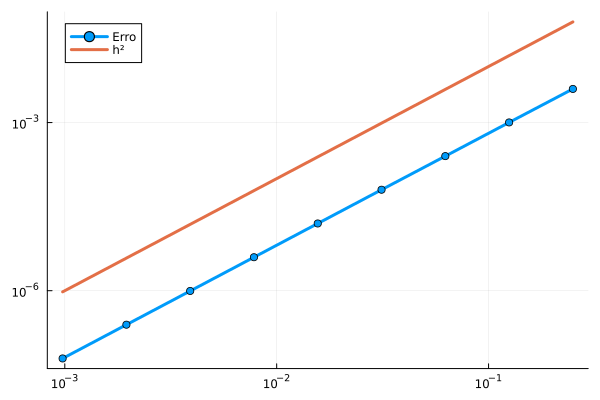

Row,h,erro
,Any,Any
1,0.25,0.00398034
2,0.125,0.0010052
3,0.0625,0.000251949
4,0.03125,6.33036e-5
5,0.015625,1.58247e-5
6,0.0078125,3.9563e-6
7,0.00390625,9.89128e-7
8,0.00195312,2.47282e-7
9,0.000976562,6.18204e-8


In [37]:
estudo_convergencia_parabolico(1, 1, 1, f2_parabolica, u2_parabolica, u0, 10)